# Задание

Проанализировать данные по выживаемости. Обучить модель предсказания выживет ли человек или нет (ключевая переменная) (различные варианты визуализации можно посмотреть здесь https://www.kaggle.com/competitions/titanic/code?competitionId=3136&sortBy=scoreDescending&language=Python).
Определить наиболее значимые переменные которые влияют на выживаемость. 
Визуализировать дерево решений. 
Написать вывод.


Ответить на вопросы
1. Как влияет размер семьи  на вероятность виживаемости (одинокие выживают чаще или нет?, люди у которых большая семья (больше 4) выживают чаще или нет).
2. Как влияет пол/возраст/номер палубы. 

# Решение

In [284]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn import tree

## Загрузка модели

In [285]:
train_df = pd.read_csv('titanic/train.csv', sep=',', index_col='PassengerId')
train_df.head(5)

Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  
PassengerId                                                          
1                1      0         A/5 21171   7.2500   NaN        S  
2                1      0          PC 17599  71.2833   C85        C  
3                0      0  STON/O2. 3101282   7.9250   NaN        S  
4                1      0            113803  53.1000  C123        S  
5                0      0            373450   8.0500   NaN        S

In [286]:
X_test = pd.read_csv('titanic/test.csv', sep=',', index_col='PassengerId')
y_test = pd.read_csv('titanic/gender_submission.csv', sep=',').Survived

## Обработка данных

In [287]:
def prepare_data(X):
    X.Cabin.fillna('U', inplace=True)
    for deck in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'U']:
        X.loc[X.Cabin.str.contains(deck), 'Deck'] = deck
    
    X.Embarked.fillna('S', inplace=True)
    X.Age.fillna(X.groupby(['Pclass','Sex'])['Age'].transform('median'), inplace=True)
    X.Fare.fillna(0.0, inplace=True)

    X = pd.concat([X,
                pd.get_dummies (X.Sex, prefix = 'Sex'),
                pd.get_dummies (X.Embarked, prefix = 'Embarked'),
                pd.get_dummies (X.Deck, prefix = 'Deck')],
                axis=1)

    X.drop(columns=['Name', 'Cabin', 'Ticket', 'Sex', 'Embarked', 'Deck'], inplace=True)

    return X

In [288]:
y_train = train_df.Survived
X_train = train_df.drop(columns='Survived')

In [289]:
X_train = prepare_data(X_train)

In [290]:
X_test = prepare_data(X_test)
# в тестовом датасете отсутствуют записи с кабиной T. Заводим
X_test.insert(17, 'Deck_T', np.zeros(X_test.shape[0], dtype=np.uint8))

In [291]:
print(X_test.shape)
print(X_train.shape)

(418, 19)
(891, 19)


## Визуализация данных

In [292]:
processed_df = pd.concat([X_train, X_test], axis=0, sort=False)


In [293]:
processed_df.insert(0, 'Survived', np.concatenate([y_train, y_test]))

<AxesSubplot: xlabel='SibSp', ylabel='count'>

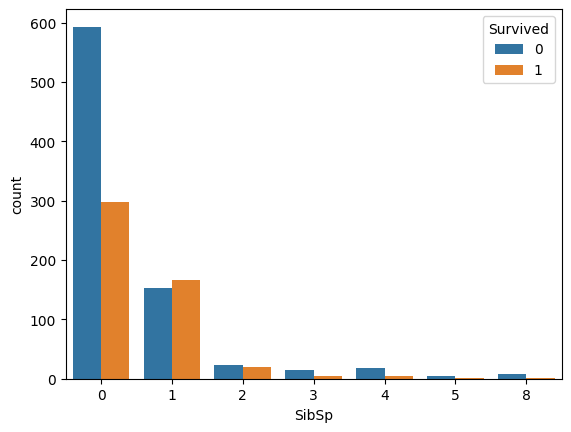

In [294]:
sns.countplot(x=processed_df.SibSp, hue='Survived', data=processed_df)

<AxesSubplot: xlabel='Sex_male', ylabel='count'>

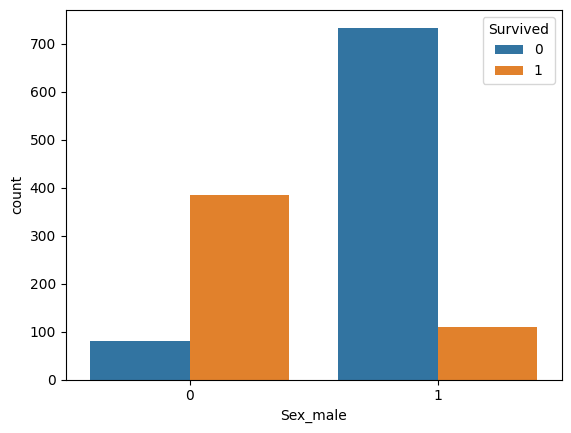

In [295]:
sns.countplot(x=processed_df.Sex_male, hue='Survived', data=processed_df)

<AxesSubplot: xlabel='Age', ylabel='count'>

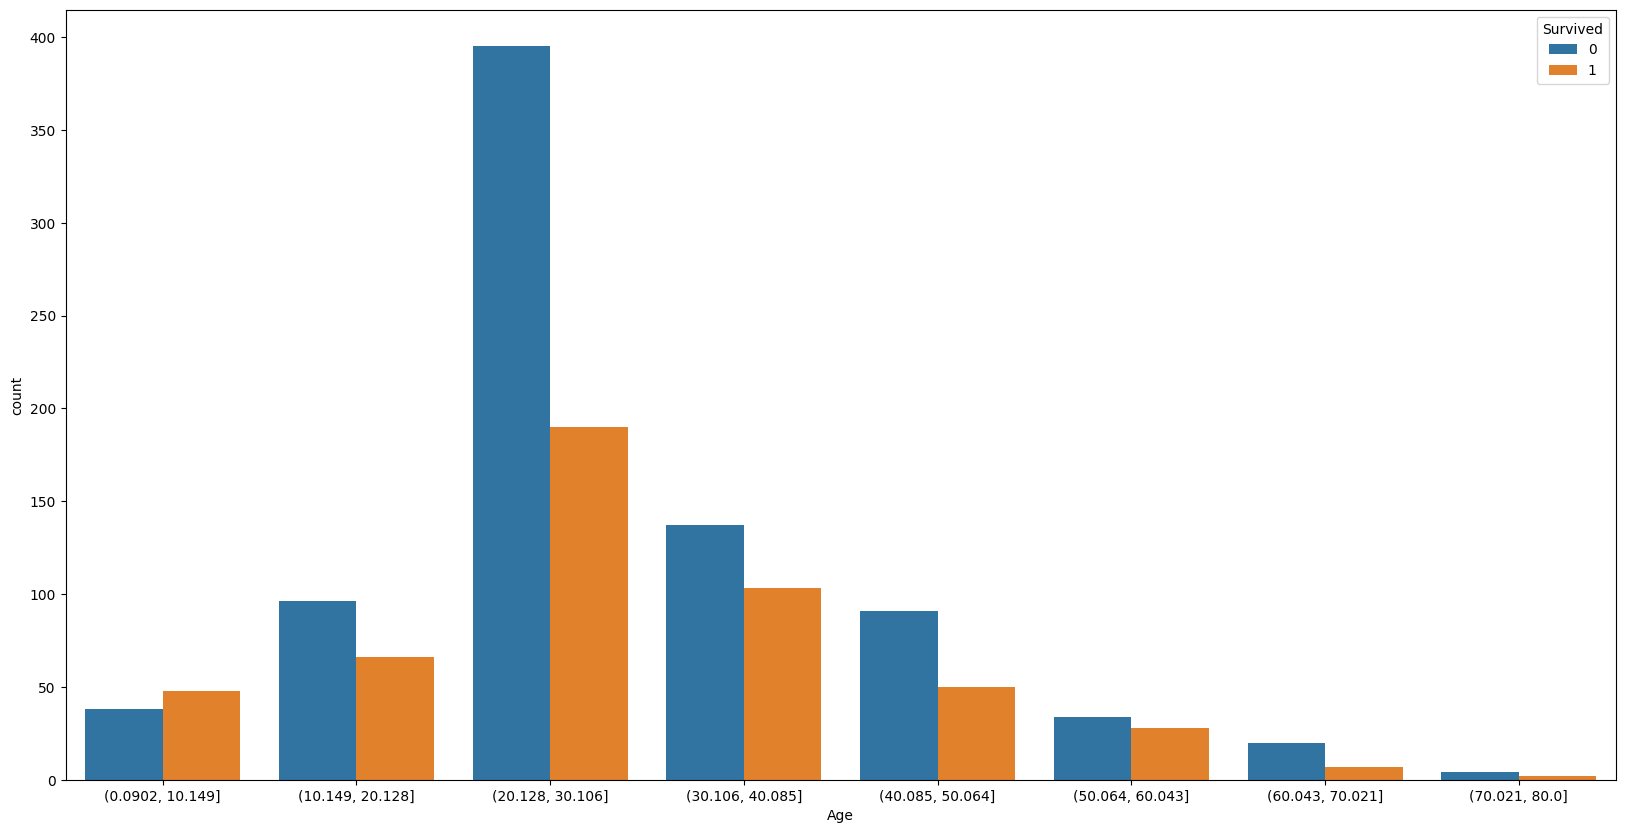

In [296]:
plt.figure(figsize=(20, 10))
sns.countplot(x=pd.cut(processed_df.Age, 8), hue='Survived', data=processed_df)

Text(0.5, 1.0, 'Survived % by decks')

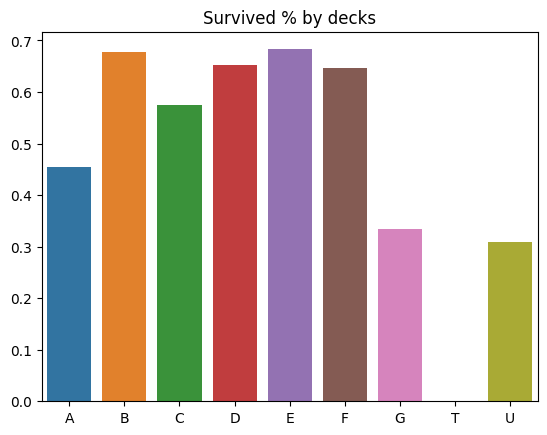

In [297]:
decks = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'U']
deck_vals = []
for deck in decks:
    deck_col = processed_df['Deck_' + deck]
    deck_vals.append(processed_df[deck_col == 1].Survived.sum() / deck_col.sum())

sns.barplot(x=decks, y=deck_vals).set_title('Survived % by decks')

<AxesSubplot: >

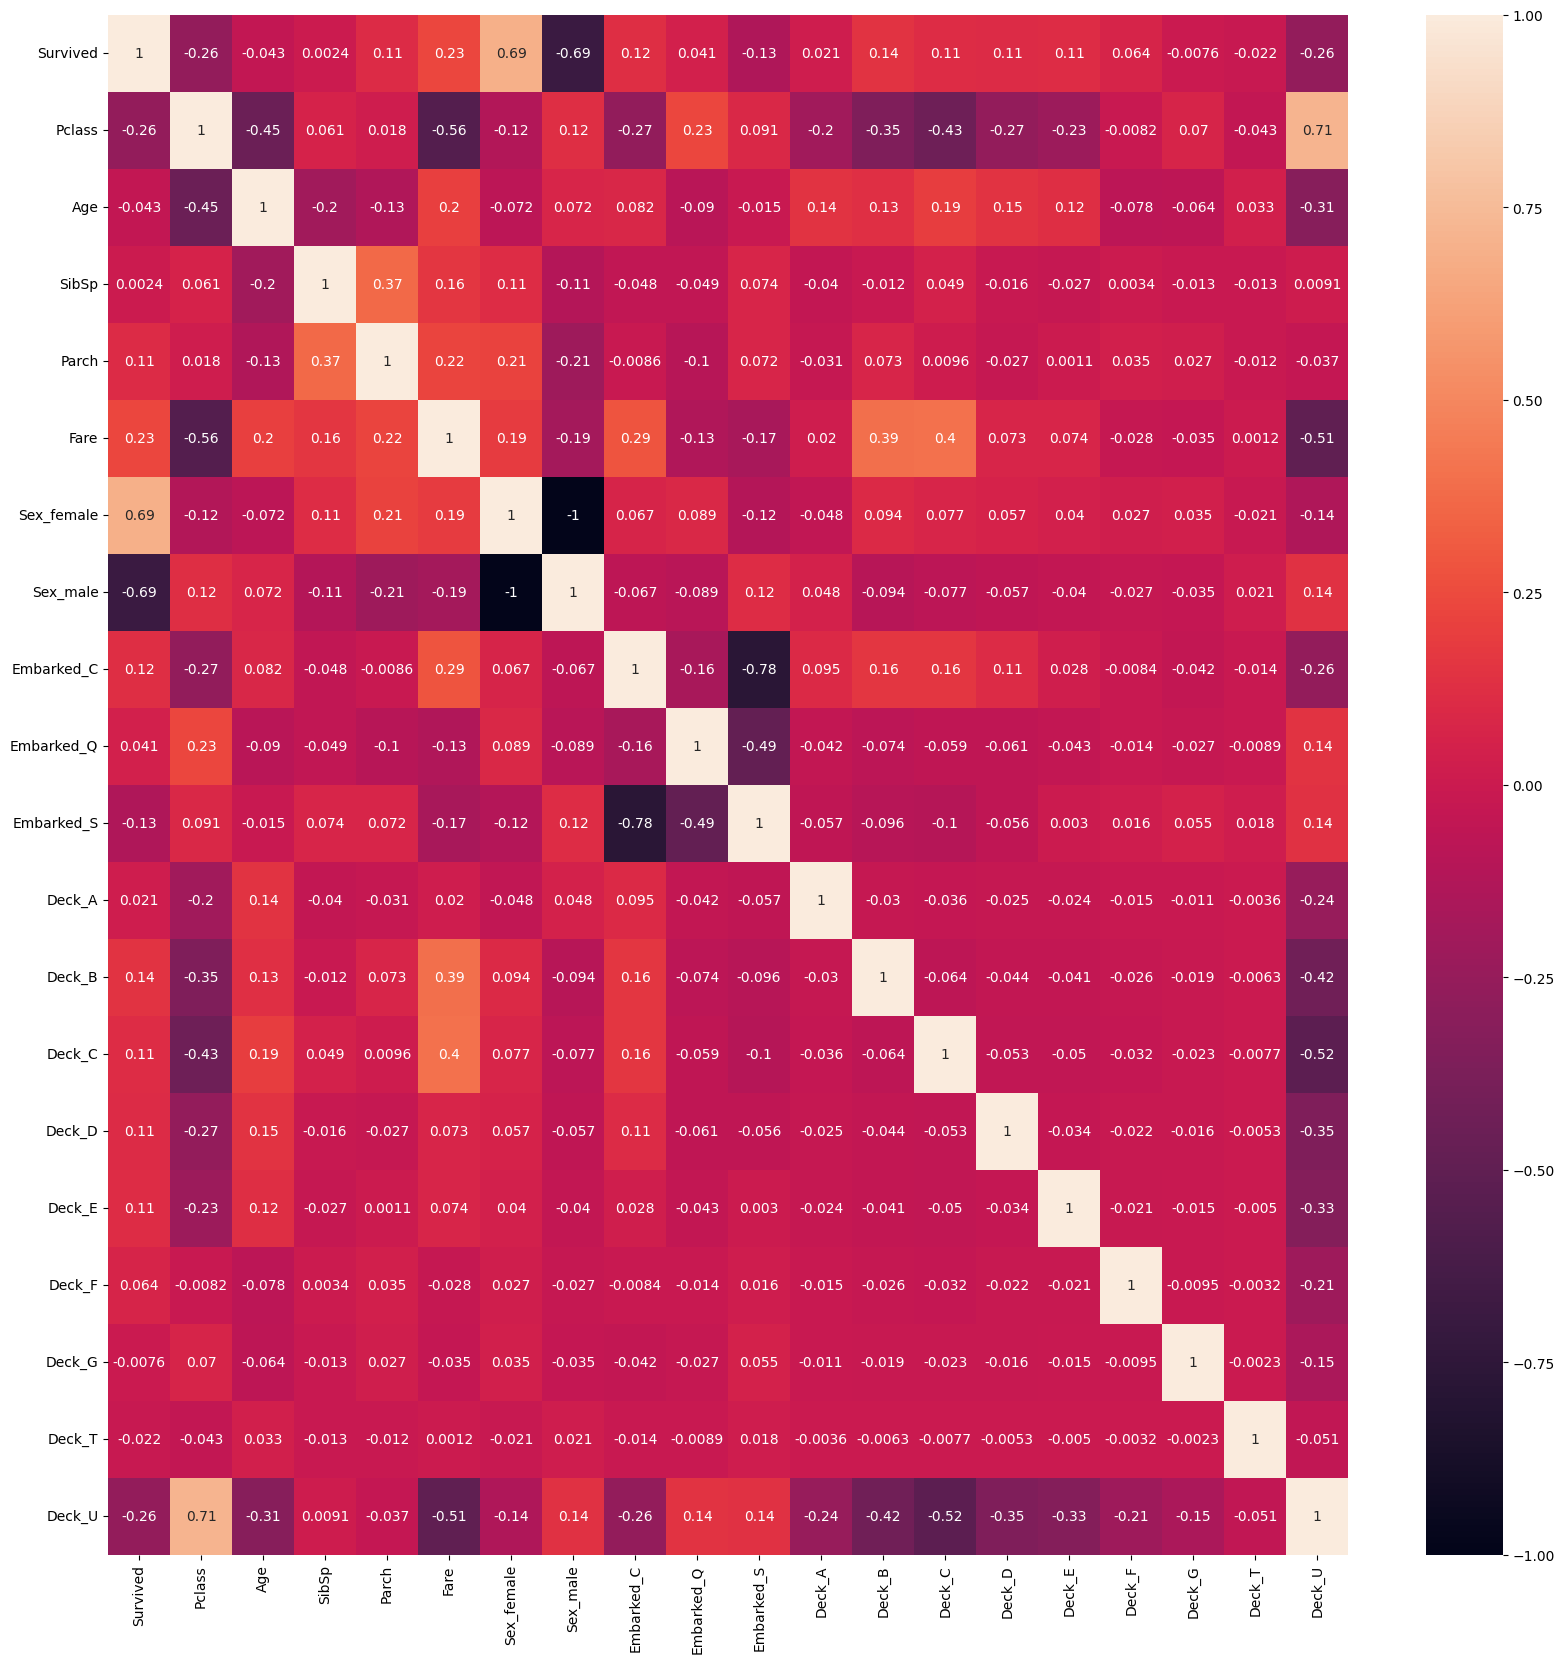

In [298]:
correlation_matrix = processed_df.corr()
plt.figure(figsize = (20, 20))
sns.heatmap(correlation_matrix, annot=True)

Можно выделить три признака с повышенной корреляцией с `Survived`: `Pclass`, `Sex_male`, `Sex_female`. Из интересного корреляция `Pclass` и `Deck_U`

## Обучение модели

In [299]:
grid = { 'n_estimators': range (50, 500, 50),
              'max_depth': range (5, 50, 5),
              'min_samples_leaf': range (2,7,2),
             'min_samples_split': range (2,7,2) }

rfc_grid = GridSearchCV(estimator=RandomForestClassifier(),
                 param_grid=grid, 
                 cv=2,
                 scoring='accuracy',
                 n_jobs=-1)

rfc_grid.fit(X_train, y_train)

rfc = rfc_grid.best_estimator_

rfc_grid.best_params_

{'max_depth': 40,
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 250}

In [300]:
y_pred = rfc.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred)

0.9493717847249703

<AxesSubplot: >

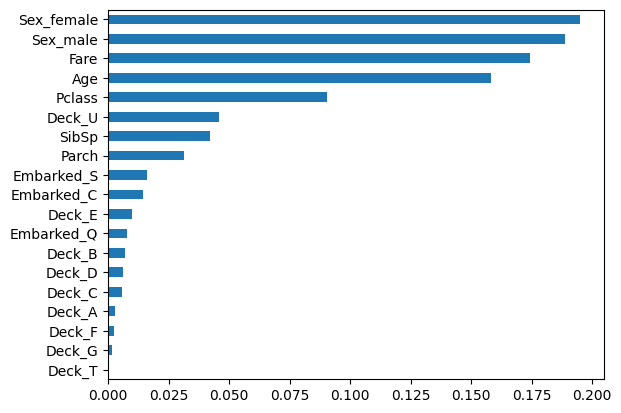

In [301]:
feature_importances = pd.Series(rfc.feature_importances_, index=X_test.columns)
feature_importances.sort_values().plot(kind='barh')

In [302]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(20, 15), dpi=800)
tree.plot_tree(rfc.estimators_[0],
               feature_names=X_test.columns,
               filled = True);

## Выводы:

1. Наилучшее соотношение выживших к умершим у пассажиров с 1-2 родственниками
2. Быть мужчиной отрицательно сказывается на выживаемости
3. 0-10 лет - единственная возрастная группа, в которой выживших больше, чем умерших. Лидеры по смертности в процентном соотношении: 60-70, 70-80, 20-30. По количеству: 20-30, 30-40, 10-20
4. По палубам лидеры по выживаемости E, B, D, F, соответственно
5. Поле `Name` при моделировании лучше не учитывать
6. Наиболее значимые признаки: `Sex_female`, `Fare`, `Sex_male`, `Age`, `Pclass`